# Jupyter Notebook for the Computational Experiment

This notebook contains code used to run the computational experiment presented in the paper "Leveraging Loop Polarity to Reduce Underspecification in Deep Learning."  

### Import packages and define functions

In [ ]:
# Import the the required packages
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tqdm import tqdm


def system(y,t,N,beta,gamma):
  """
    Defines a system of ordinary differential equations that contains the
    three main equations of the SIR model.

    Args:
        y: A list or array of three elements [S, I, R].
        t: Time variable (included for compatibility with ODE solvers).
        N: Total population size.
        beta: Transmission rate parameter.
        gamma: Recovery rate parameter.

    Returns:
        list: A list containing the derivatives [dS/dt, dI/dt, dR/dt] at time t.
    """
  S,I,R = y
  dydt = [-beta*I*S/N, beta*I*S/N-gamma*I, gamma*I]
  return dydt


def loop_system(y,t,I,S,N,est_beta,est_gamma):
  """
  Defines a system of ordinary differential equations that the contains the
  equations for the loops of the SIR model, allowing us to calculate the
  estimated polarities of the loops.

  Args:
        y (list or array-like): A list or array of two elements [L1, L2].
        t: Time variable (included for compatibility with ODE solvers).
        I: Current number of infected individuals.
        S: Current number of susceptible individuals.
        N: Total population size.
        est_beta: Estimated transmission rate parameter.
        est_gamma: Estimated recovery rate parameter.

    Returns:
        A list containing the derivatives [dL1/dt, dL2/dt] at time t.
  """
  L1,L2 = y
  dLdt = [est_beta*I*S/N,est_gamma*I]
  return dLdt

def sir_model_all(t, beta, gamma):
    """
    Solves the SIR model using given parameters over a time grid.

    Args:
        t: Array of time points at which to solve the system.
        beta: Transmission rate parameter.
        gamma: Recovery rate parameter.

    Returns:
        A flattened NumPy array containing the solution of the SIR model over
        time.
    """
    N = 1000000
    y0 = [N-1, 1, 0]
    sol = odeint(system, y0, t, args=(N, beta, gamma))
    return sol.reshape(-1)


def get_loop_data(data_point,beta,gamma):
  """
    Computes the estimated values of the infection and recovery loop for a
    specific time period.;

    Args:
        data_point: A list or array containing at least two elements,
            where data_point[0] is the number of susceptible individuals (S),
            and data_point[1] is the number of infected individuals (I).
        beta: Transmission rate parameter.
        gamma: Recovery rate parameter.

    Returns:
        ndarray: A NumPy array [L1, L2].
    """
  S = data_point[0]
  I = data_point[1]
  return np.array([beta*I*S/N,gamma*I])


def binary_repro(x):
  """Converts the effectivve reproduction number to a binary value.

  Args:
    x: The effective reproduction number.

  Returns:
    1 if x > 1, 0 otherwise.
  """
  if x >= 1:
      return 1
  if x < 1:
      return 0


def sample_truncated_normal(mean, std_dev, lower, upper, size=1000):
    """
    Samples from a truncated normal distribution.

    Args:
        mean (float): Mean of the original normal distribution.
        std_dev (float): Standard deviation of the original normal distribution.
        lower (float): Lower bound of truncation.
        upper (float): Upper bound of truncation.
        size (int): Number of samples to draw.

    Returns:
        np.ndarray: Array of truncated normal samples.
    """
    # Convert to the standard normal scale for truncnorm
    a, b = (lower - mean) / std_dev, (upper - mean) / std_dev
    samples = stats.truncnorm.rvs(a, b, loc=mean, scale=std_dev, size=size)
    return samples

def bucket_averages(arr, bucket_size=100):
  """Helper function used to visualize test performance."""
  n_buckets = len(arr) // bucket_size
  return np.array([
      np.mean(arr[i * bucket_size:(i + 1) * bucket_size])
      for i in range(n_buckets)
  ])

### Generate simulated data from 100 epidemics.



In [ ]:
number_of_epidemics = 100 #Can set this to other values to experiment.
t = np.arange(0,100) # Set the number of time periods per epidemic.

#Define zero matrices store inputs and outputs.
rawdata_inputs = np.zeros((98*number_of_epidemics,9))
loop_inputs = np.zeros((98*number_of_epidemics,2))
outputs = np.zeros((98*number_of_epidemics,1))
for j in tqdm(range(0,number_of_epidemics)): #Loop through all epidemics.
    N = 1000000 #Set the size of the population.
    S_0 = N-1 #Set the number of susceptible people.
    I_0 = 1 #Set the number of infected people.
    R_0 = 0 #Set the number of recovered people.
    trunc_dist_mean = 1 #Set the mean value of the truncated normal
    #distribution from which beta is sampled at each time period.
    beta_dist_mean2 = .1 #Set the mean value of the beta
    #distribution from which gamma is sampled at each time period.

    #Sample beta for the first time period.
    beta = sample_truncated_normal(trunc_dist_mean,.5,0,np.inf,1)[0]
    #Sample gamma for the first time period.
    gamma = np.random.beta(2,(2-2*beta_dist_mean2)/beta_dist_mean2)

    #Define a zero matrix to store epidemic data.
    data = np.zeros((100,3))
    #Initialize the system of differential equations.
    data[0] = [S_0,I_0,R_0]
    #Interate the system of differential equations for one time period.
    data[1] = odeint(system, data[0], [1,2], args=(N,beta,gamma))[1]
    #Iterate the system of equations for all 100 time periods.
    for i in range(2,100):
        beta = sample_truncated_normal(trunc_dist_mean,.5,0,np.inf,1)[0]
        gamma = np.random.beta(2,(2-2*beta_dist_mean2)/beta_dist_mean2)
        data[i] = odeint(system, data[i-1], [1,2], args=(N,beta,gamma))[1]

    #Store the inputs for the training data for the naive approach.
    rawdata_step_inputs = np.zeros((98,9))
    for i in range(98):
        rawdata_step_inputs[i] = [data[i][0],data[i][1],data[i][2],data[i+1][0],
                                  data[i+1][1],data[i+1][2],data[i+2][0],
                                  data[i+2][1],data[i+2][2]]
    rawdata_inputs[j*98:(j+1)*98] = rawdata_step_inputs

    #Estimate the mean value of beta and gamma for the entire epidemic.
    flat_data = data.reshape(-1)
    p0 = [1, 1]
    popt, pcov = curve_fit(sir_model_all, t, flat_data, p0=p0,
                           bounds=(0, np.inf))
    est_beta = popt[0]
    est_gamma = popt[1]

    #Store the inputs for the training data for the SD-inspired approach.
    loop_step_inputs = np.zeros((98,2))
    loop_data = np.zeros((100,2))
    loop_data[0] = get_loop_data(data[0],est_beta,est_gamma)
    loop_data[1] = get_loop_data(data[1],est_beta,est_gamma)
    for i in range(98):
        loop_data[i+2] = odeint(loop_system, loop_data[i+1], [i+1,i+2],
                                args=(data[i+1][1],data[i+1][0],N,est_beta,
                                      est_gamma))[1]
        num1 = loop_data[i+2] - loop_data[i+1]
        num2 = loop_data[i+1] - loop_data[i]
        denom = loop_data[i+2] + loop_data[i]
        loop_step_inputs[i] = np.sign((num1-num2)/denom)
    loop_inputs[j*98:(j+1)*98] = loop_step_inputs

    #Store the output values of the binary effective reproduction number.
    step_outputs = np.array([[binary_repro(1+(1/gamma)*(beta*data[i][0]/N -
                                                gamma))] for i in range(2,100)])
    outputs[j*98:(j+1)*98] = step_outputs

100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


# Train the baseline model

Produce a graph showing accuracy and loss during training.

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9261 - loss: 0.1544
Accuracy: 93.58


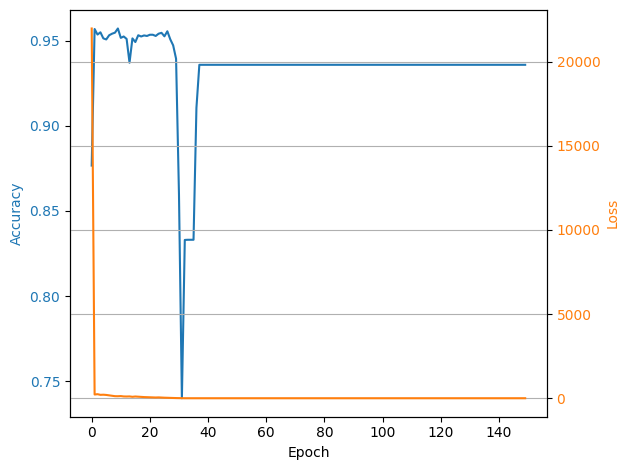

In [ ]:
# Define the model
model_rawdata = Sequential()
model_rawdata.add(Dense(9, input_shape=(9,), activation='relu'))
model_rawdata.add(Dense(9, activation='relu'))
model_rawdata.add(Dense(1, activation='sigmoid'))

# Compile the model
model_rawdata.compile(loss='binary_crossentropy', optimizer='adam',
                      metrics=['accuracy'])

# Fit the model and store training history
history = model_rawdata.fit(rawdata_inputs, outputs, epochs=150, batch_size=10,
                            verbose=0)

# Evaluate the model
_, accuracy = model_rawdata.evaluate(rawdata_inputs, outputs)
print('Accuracy: %.2f' % (accuracy*100))

# Plot with dual y-axes
fig, ax1 = plt.subplots()

# Plot accuracy on left y-axis
ax1.plot(history.history['accuracy'], color='tab:blue', label='Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(history.history['loss'], color='tab:orange', label='Loss')
ax2.set_ylabel('Loss', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add title and grid
fig.tight_layout()
plt.grid(True)
plt.show()

# Train the SD-inspired model

Produce a graph showing accuracy and loss during training.

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9782 - loss: 0.0682
Accuracy: 97.89


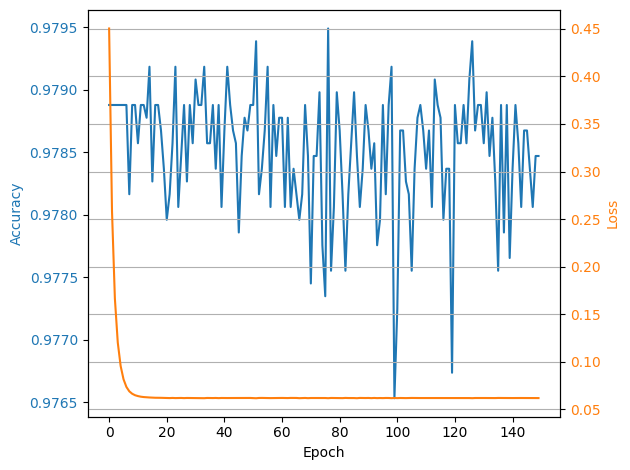

In [ ]:
model_loops = Sequential()
model_loops.add(Dense(2, input_shape=(2,), activation='relu'))
model_loops.add(Dense(2, activation='relu'))
model_loops.add(Dense(1, activation='sigmoid'))

# compile the keras model
model_loops.compile(loss='binary_crossentropy', optimizer='adam',
                    metrics=['accuracy'])
# fit the keras model on the dataset
history = model_loops.fit(loop_inputs, outputs, epochs=150, batch_size=10,
                          verbose=0)
# # evaluate the keras model
_, accuracy = model_loops.evaluate(loop_inputs, outputs)
print('Accuracy: %.2f' % (accuracy*100))



# Plot with dual y-axes
fig, ax1 = plt.subplots()

# Plot accuracy on left y-axis
ax1.plot(history.history['accuracy'], color='tab:blue', label='Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(history.history['loss'], color='tab:orange', label='Loss')
ax2.set_ylabel('Loss', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add title and grid
fig.tight_layout()
plt.grid(True)
plt.show()

# Generate 20 OOD Epidemics

In [ ]:
#Define empty lists to store the accuracy of classifications generated by both
#models
rawdata_accuracies = []
loop_accuracies = []
for x in tqdm(range(0,20)): #Loop through 20 simulated epidemics.
    for j in range(0,100): #Loop through 100 time periods for each epidemic.
        N = 1000000 #Set the size of the population.
        S_0 = N-1 #Set the number of susceptible people.
        I_0 = 1 #Set the number of infected people.
        R_0 = 0 #Set the number of recovered people.
        trunc_dist_mean = 5 #Set the mean value of the truncated normal
        #distribution from which beta is sampled at each time period. Note that
        #the chosen value is very different from the value used to generate
        #the training data.
        beta_dist_mean2 = .01 #Set the mean value of the beta
        #distribution from which gamma is sampled at each time period. Note that
        #the chosen value is very different from the value used to generate
        #the training data.

        #Sample beta for the first time period.
        beta = sample_truncated_normal(trunc_dist_mean,.5,0,np.inf,1)[0]

        #Sample gamma for the first time period.
        gamma = np.random.beta(2,(2-2*beta_dist_mean2)/beta_dist_mean2)

        #Define a zero matrix to store epidemic data.
        data = np.zeros((100,3))
        #Initialize the system of differential equations.
        data[0] = [S_0,I_0,R_0]
        #Interate the system of differential equations for one time period.
        data[1] = odeint(system, data[0], [1,2], args=(N,beta,gamma))[1]
        #Iterate the system of equations for all 100 time periods.
        for i in range(2,100):
            beta = sample_truncated_normal(trunc_dist_mean,.5,0,np.inf,1)[0]
            gamma = np.random.beta(2,(2-2*beta_dist_mean2)/beta_dist_mean2)
            data[i] = odeint(system, data[i-1], [1,2], args=(N,beta,gamma))[1]

        #Store the inputs for the training data for the naive approach.
        rawdata_step_inputs = np.zeros((98,9))
        for i in range(98):
            rawdata_step_inputs[i] = [data[i][0],data[i][1],
                                      data[i][2],data[i+1][0],
                                      data[i+1][1],data[i+1][2],
                                      data[i+2][0],data[i+2][1],
                                      data[i+2][2]]
            rawdata_inputs[j*98:(j+1)*98] = rawdata_step_inputs

        #Estimate the mean value of beta and gamma for the entire epidemic.
        flat_data = data.reshape(-1)
        p0 = [1, 1]
        popt, pcov = curve_fit(sir_model_all, t, flat_data, p0=p0,
                               bounds=(0, np.inf))
        est_beta = popt[0]
        est_gamma = popt[1]

        #Store the inputs for the training data for the SD-inspired approach.
        loop_step_inputs = np.zeros((98,2))
        loop_data = np.zeros((100,2))
        loop_data[0] = get_loop_data(data[0],est_beta,est_gamma)
        loop_data[1] = get_loop_data(data[1],est_beta,est_gamma)
        for i in range(98):
            loop_data[i+2] = odeint(loop_system, loop_data[i+1], [i+1,i+2],
                                    args=(data[i+1][1],data[i+1][0],N,est_beta,
                                          est_gamma))[1]
            num1 = loop_data[i+2] - loop_data[i+1]
            num2 = loop_data[i+1] - loop_data[i]
            denom = loop_data[i+2] - loop_data[i]
            # Add a small epsilon to the denominator to avoid division by zero
            denom[denom == 0] = 1e-10
            loop_step_inputs[i] = np.sign((num1-num2)/denom)
        loop_inputs[j*98:(j+1)*98] = loop_step_inputs

        #Store the output values of the binary effective reproduction number.
        step_outputs = np.array([[binary_repro(1+(1/gamma)*(1/data[i][1])
                        *(beta*data[i][0]/N - gamma))] for i in range(2,100)])


        #Generate preditions of the binary effective reproduction number at
        #each time period, using the baseline approach.
        rawdata_predictions = model_rawdata.predict(rawdata_step_inputs,
                                                    verbose=0)

        #Calculate the and store the accuracy of the predictions generated using
        #the baseline method.
        rawdata_accuracy = np.mean([(round(rawdata_predictions[i][0])
              -step_outputs[i][0])**2 for i in range(len(rawdata_predictions))])

        rawdata_accuracies = np.append(rawdata_accuracies,1 - rawdata_accuracy)

        #Calculate the and store the accuracy of the predictions generated using
        #the SD-inspired method.
        loop_predictions = model_loops.predict(loop_step_inputs,verbose=0)
        loop_accuracy = np.mean([(round(loop_predictions[i][0])
                -step_outputs[i][0])**2 for i in range(len(loop_predictions))])
        loop_accuracies = np.append(loop_accuracies,1 - loop_accuracy)

#Print the mean accuracy of each approach.
print(f'Raw data accuracy: {str(np.mean(rawdata_accuracies))}')
print(f'Loop polarity accuracy: {str(np.mean(loop_accuracies))}')

100%|██████████| 20/20 [07:41<00:00, 23.10s/it]

Raw data accuracy: 0.7996173469387755
Loop polarity accuracy: 0.9961275510204082


# T-test

Run a t-test comparing the accuracy of models trained using the baseline pipeline versus the SD-inspired pipeline with respect to classifying the binary effective reproduction number at each time period in an out-of-distribution epidemic.

In [ ]:
stats.ttest_rel(loop_accuracies,rawdata_accuracies)

TtestResult(statistic=np.float64(280.69571512445583), pvalue=np.float64(0.0), df=np.int64(1999))

# Graph the Accuracy of Each Method Across All OOD epidemics.

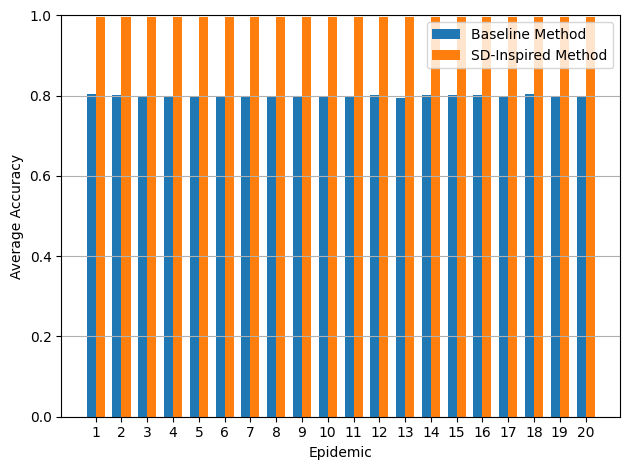

In [ ]:
# Compute averages in 100-entry buckets
raw_avg = bucket_averages(rawdata_accuracies, 100)
loop_avg = bucket_averages(loop_accuracies, 100)

# Plotting
x = np.arange(1,len(raw_avg)+1)  # bucket indices
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, raw_avg, width, label='Baseline Method')
bars2 = ax.bar(x + width/2, loop_avg, width, label='SD-Inspired Method')

# Labels and formatting
ax.set_xlabel('Epidemic')
ax.set_ylabel('Average Accuracy')
ax.set_xticks(x)
ax.set_ylim(0, 1)  # assuming accuracy is in [0, 1]
ax.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()